In [1]:
!pip3 install numpy pandas seaborn matplotlib --quiet

In [2]:
# import python libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # visualizing data
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
import seaborn as sns
import sqlite3

In [3]:
# import csv file
URL = 'https://github.com/rishabhnmishra/Python_Diwali_Sales_Analysis/raw/main/Diwali%20Sales%20Data.csv'
df = pd.read_csv(URL, encoding = 'unicode_escape')

In [4]:
rows, columns = df.shape
print(f"There are {rows:,} rows and {columns} columns in the dataset.")

There are 11,251 rows and 15 columns in the dataset.


In [5]:
df.head()

,User_ID,Cust_name,Product_ID,Gender,Age Group,Age,Marital_Status,State,Zone,Occupation,Product_Category,Orders,Amount,Status,unnamed1
0,1002903,Sanskriti,P00125942,F,26-35,28,0,Maharashtra,Western,Healthcare,Auto,1,23952.0,NaN,NaN
1,1000732,Kartik,P00110942,F,26-35,35,1,Andhra Pradesh,Southern,Govt,Auto,3,23934.0,NaN,NaN
2,1001990,Bindu,P00118542,F,26-35,35,1,Uttar Pradesh,Central,Automobile,Auto,3,23924.0,NaN,NaN
3,1001425,Sudevi,P00237842,M,0-17,16,0,Karnataka,Southern,Construction,Auto,2,23912.0,NaN,NaN
4,1000588,Joni,P00057942,M,26-35,28,1,Gujarat,Western,Food Processing,Auto,2,23877.0,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11251 entries, 0 to 11250
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_ID           11251 non-null  int64  
 1   Cust_name         11251 non-null  object 
 2   Product_ID        11251 non-null  object 
 3   Gender            11251 non-null  object 
 4   Age Group         11251 non-null  object 
 5   Age               11251 non-null  int64  
 6   Marital_Status    11251 non-null  int64  
 7   State             11251 non-null  object 
 8   Zone              11251 non-null  object 
 9   Occupation        11251 non-null  object 
 10  Product_Category  11251 non-null  object 
 11  Orders            11251 non-null  int64  
 12  Amount            11239 non-null  float64
 13  Status            0 non-null      float64
 14  unnamed1          0 non-null      float64
dtypes: float64(3), int64(4), object(8)
memory usage: 1.3+ MB


In [7]:
null_df = round(df.isnull().sum()/len(df)*100,2).to_frame()\
                .sort_values(by=0, ascending=False).reset_index()\
                .rename(columns={'index':'Column', 0: 'Null_Pct'})
cols_to_drop = null_df.query('Null_Pct>50')['Column'].values.tolist()

In [8]:
df.drop(columns=cols_to_drop, inplace=True)
df = df.iloc[df['Amount'].dropna().index]

In [9]:
# change data type
df['Amount'] = df['Amount'].astype('int')
df['Marital_Status'] = df['Marital_Status'].astype(bool)

In [10]:
# use describe() for specific columns
df[['Age', 'Orders', 'Amount']].describe()

,Age,Orders,Amount
count,11239.000000,11239.000000,11239.000000
mean,35.410357,2.489634,9453.610553
std,12.753866,1.114967,5222.355168
min,12.000000,1.000000,188.000000
25%,27.000000,2.000000,5443.000000
50%,33.000000,2.000000,8109.000000
75%,43.000000,3.000000,12675.000000
max,92.000000,4.000000,23952.000000


In [11]:
#Correlation of Numerical Features
df[['Age', 'Orders', 'Amount']].corr()['Amount'].to_frame()

,Amount
Age,0.030941
Orders,-0.013184
Amount,1.000000


In [12]:
conn = sqlite3.connect('Sales.db')
df.to_sql('analysis', conn, if_exists='replace', index=False)

11239

# Exploratory Data Analysis

### Gender

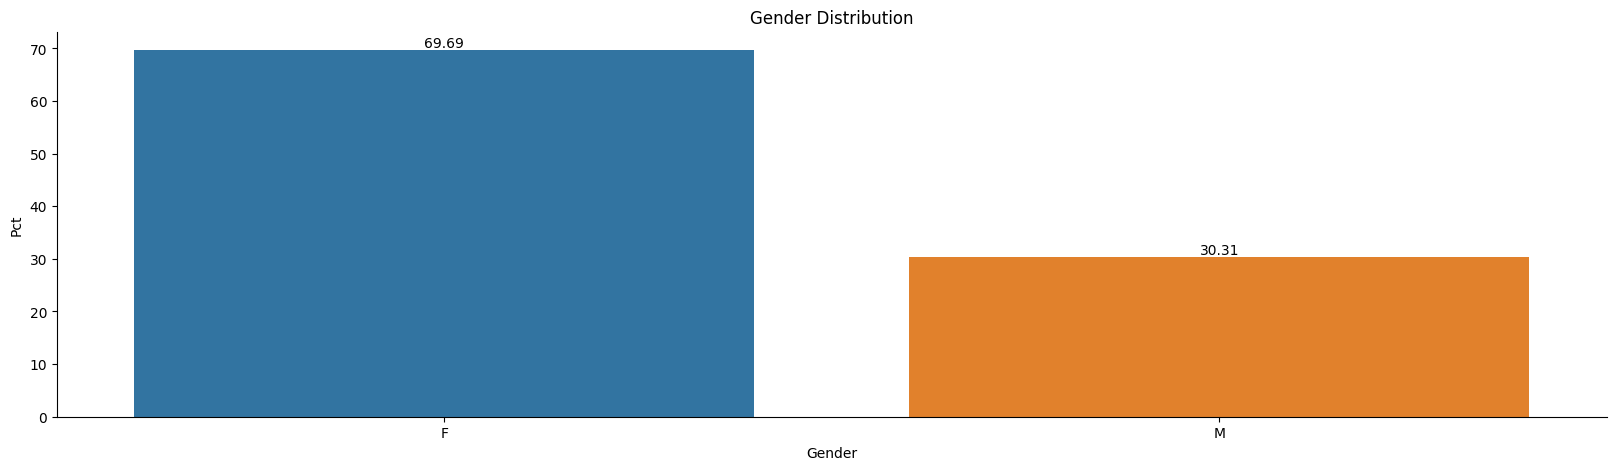

In [13]:
# plotting a bar chart for Gender and it's count
query = '''
select Gender, round(count(*)*100.0/(select count(*) from analysis),2) as Pct 
from analysis 
group by 1
'''
temp = pd.read_sql(query, conn)

ax = sns.barplot(x=temp['Gender'], y=temp['Pct'], hue=temp['Gender'])

for bars in ax.containers:
    ax.bar_label(bars)

plt.title('Gender Distribution')
plt.show()

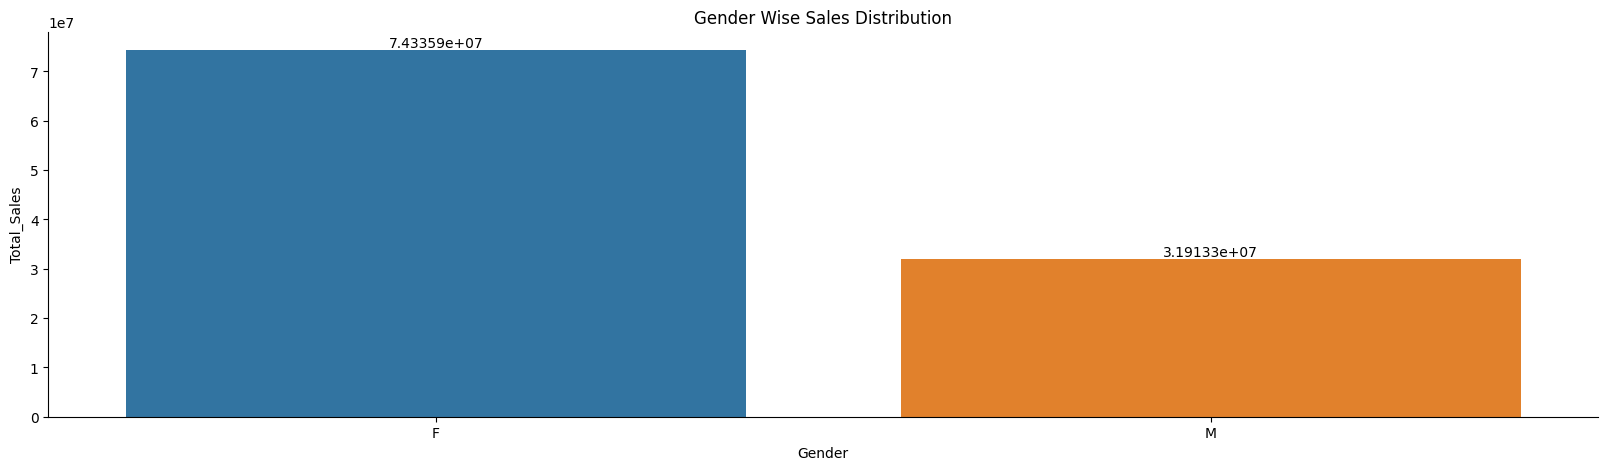

In [14]:
# plotting a bar chart for gender vs total amount
query = '''
select Gender, round(sum(Amount),2) as Total_Sales from analysis group by 1
'''
temp = pd.read_sql(query, conn)

ax = sns.barplot(x=temp['Gender'], y=temp['Total_Sales'], hue=temp['Gender'])


for bars in ax.containers:
    ax.bar_label(bars)

plt.title('Gender Wise Sales Distribution')
plt.show()

*From above graphs we can see that most of the buyers are females and even the purchasing power of females are greater than men*

### Age

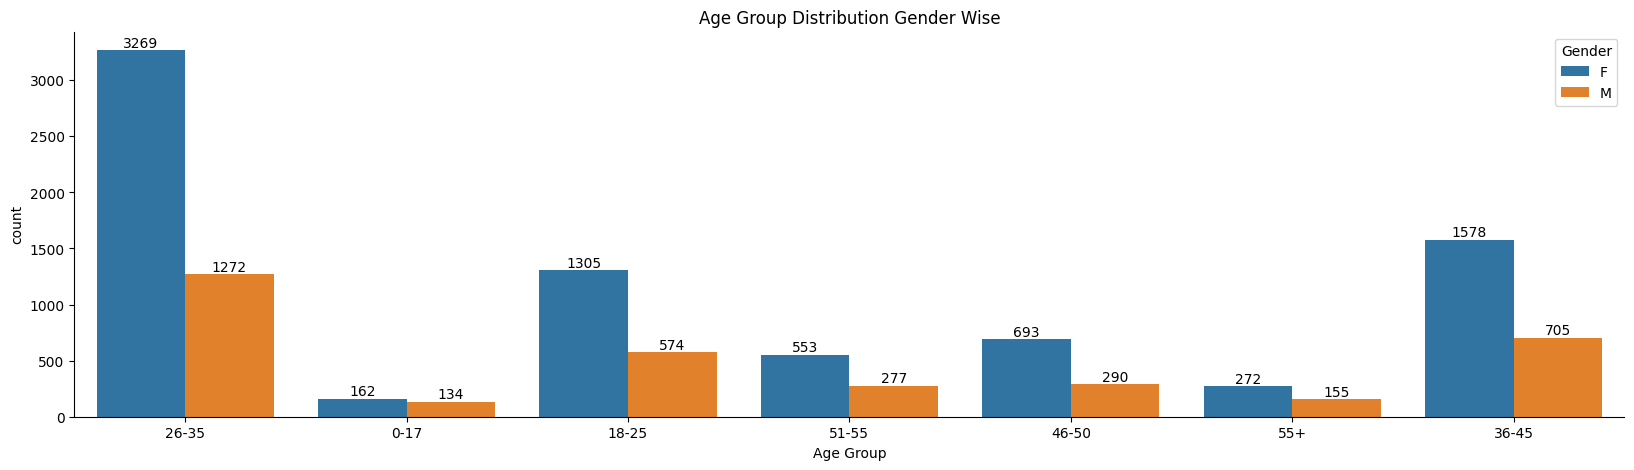

In [15]:
ax = sns.countplot(data = df, x = 'Age Group', hue = 'Gender')
plt.title('Age Group Distribution Gender Wise')
for bars in ax.containers:
    ax.bar_label(bars)

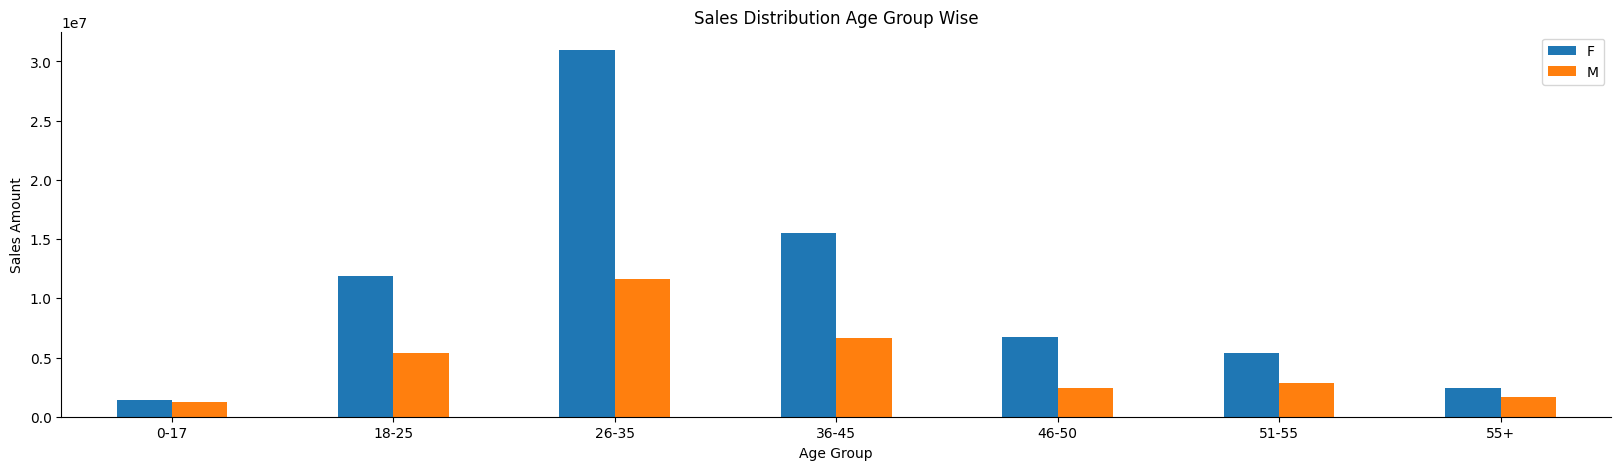

In [16]:
# Total Amount vs Age Group
sales_age = df.pivot_table(index='Age Group', columns='Gender', 
                           values='Amount', aggfunc='sum').reset_index().rename_axis(columns=None).set_index('Age Group')
sales_age.plot(kind='bar')
plt.title('Sales Distribution Age Group Wise')
plt.ylabel('Sales Amount')
plt.xticks(rotation=0)
plt.show()

*From above graphs we can see that most of the buyers are of age group between 26-35 yrs female*

### State

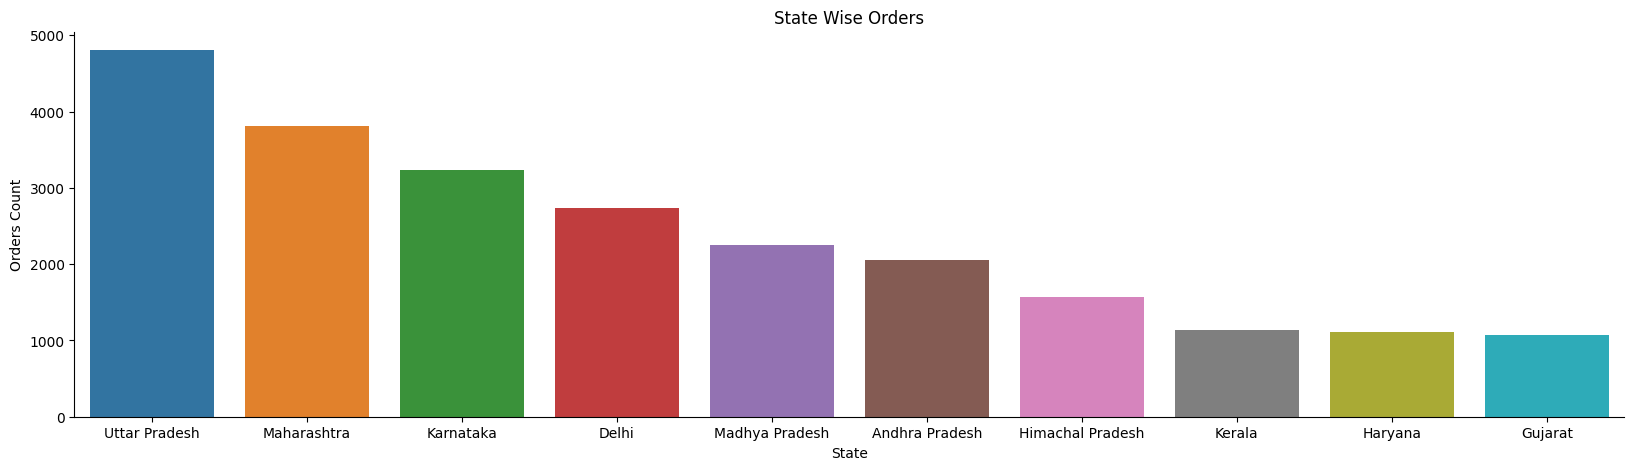

In [17]:
# total number of orders from top 10 states

sales_state = df.groupby(['State'], as_index=False)['Orders'].sum()\
                        .sort_values(by='Orders', ascending=False).head(10)
sns.barplot(data = sales_state, x = 'State',y= 'Orders', hue='State')
plt.title('State Wise Orders')
plt.ylabel('Orders Count')
plt.xticks(rotation=0)
plt.show()

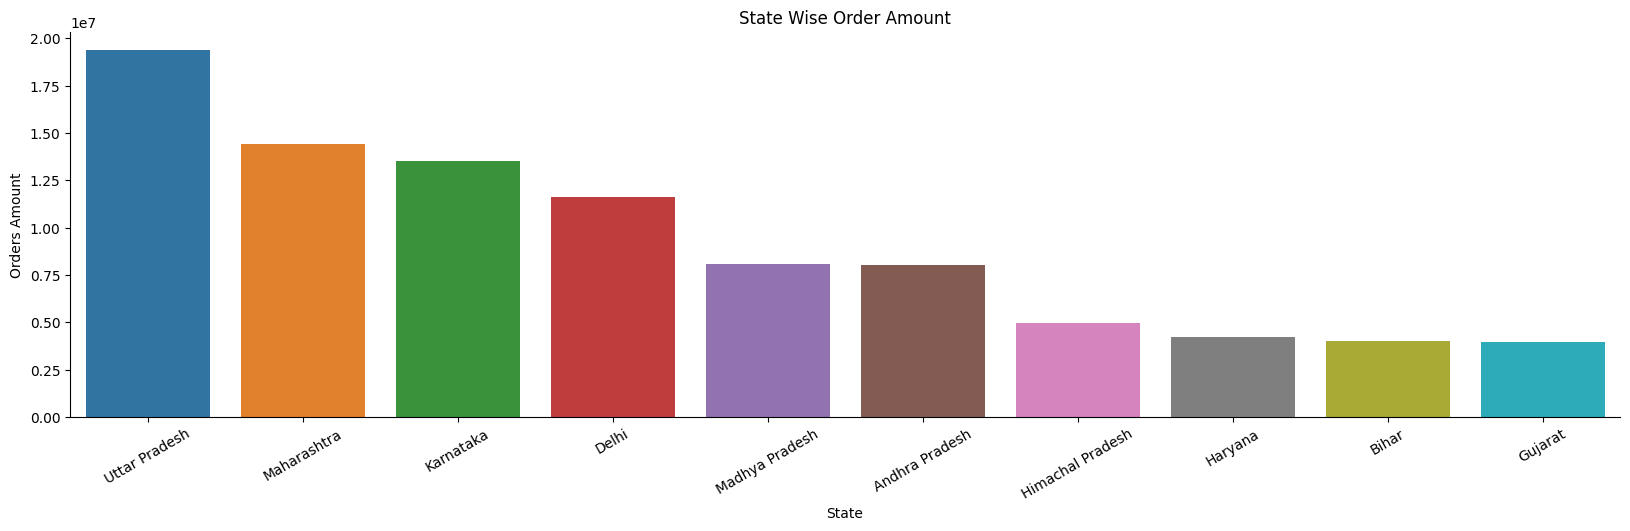

In [18]:
# total amount/sales from top 10 states

sales_state = df.groupby(['State'], as_index=False)['Amount'].sum()\
                    .sort_values(by='Amount', ascending=False).head(10)
sns.barplot(data = sales_state, x = 'State',y= 'Amount', hue='State')
plt.title('State Wise Order Amount')
plt.ylabel('Orders Amount')
plt.xticks(rotation=30)
plt.show()

*From above graphs we can see that most of the orders & total sales/amount are from Uttar Pradesh, Maharashtra and Karnataka respectively*


### Marital Status

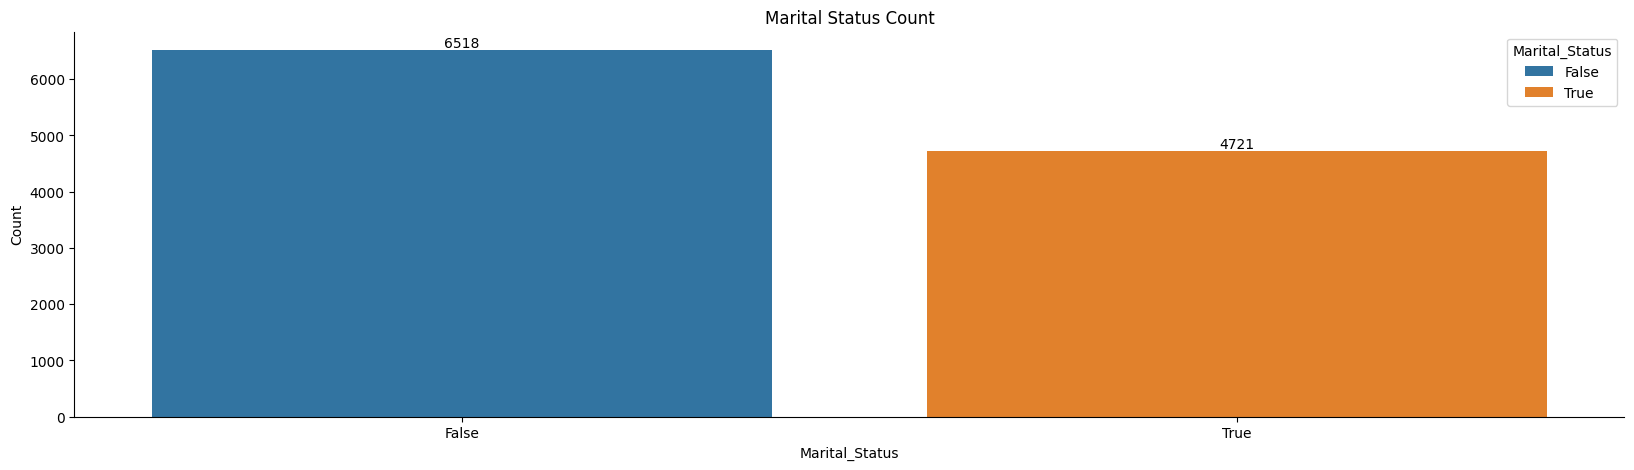

In [19]:
ax = sns.countplot(data = df, x = 'Marital_Status', hue='Marital_Status')
for bars in ax.containers:
    ax.bar_label(bars)

plt.title('Marital Status Count')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

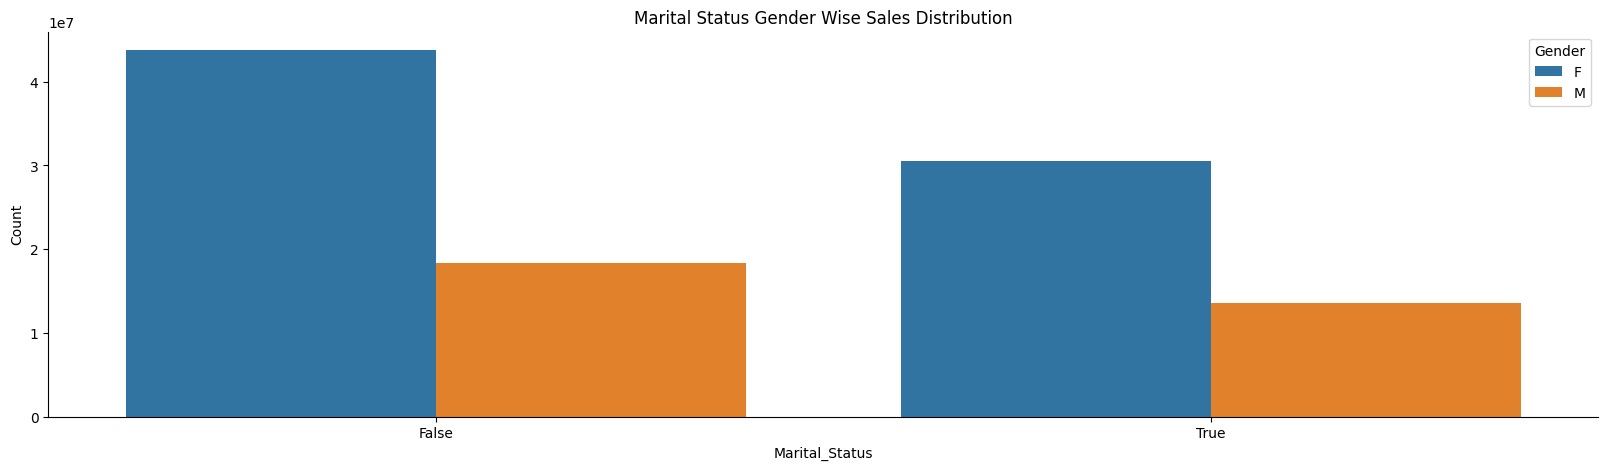

In [20]:
sales_state = df.groupby(['Marital_Status', 'Gender'], as_index=False)['Amount'].sum().sort_values(by='Amount', ascending=False)
sns.barplot(data = sales_state, x = 'Marital_Status',y= 'Amount', hue='Gender')

plt.title('Marital Status Gender Wise Sales Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

*From above graphs we can see that most of the buyers are married (women) and they have high purchasing power*

### Occupation

In [21]:
def get_colors(df, start=0.4, stop=1):
    import matplotlib.pyplot as plt
    import numpy as np
    import random
    sequential_cmaps = [
        'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'Blues', 
        'Greens', 'Oranges', 'Reds', 'YlGnBu', 'YlOrRd'
    ]

    diverging_cmaps = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 
        'Spectral', 'coolwarm', 'bwr', 'seismic'
    ]

    cyclic_cmaps = ['twilight', 'twilight_shifted', 'hsv']

    # Combine all gradient-producing colormaps
    gradient_colormaps = sequential_cmaps + diverging_cmaps + cyclic_cmaps

    # Randomly select a colormap from the list
    cmap_name = random.choice(gradient_colormaps)
    
    num_bars = len(df)
    
    # Dynamically retrieve the colormap and generate colors using the new method
    cmap = plt.colormaps[cmap_name]  # Access colormap directly
    colors = cmap(np.linspace(start, stop, num_bars))
    
    return colors

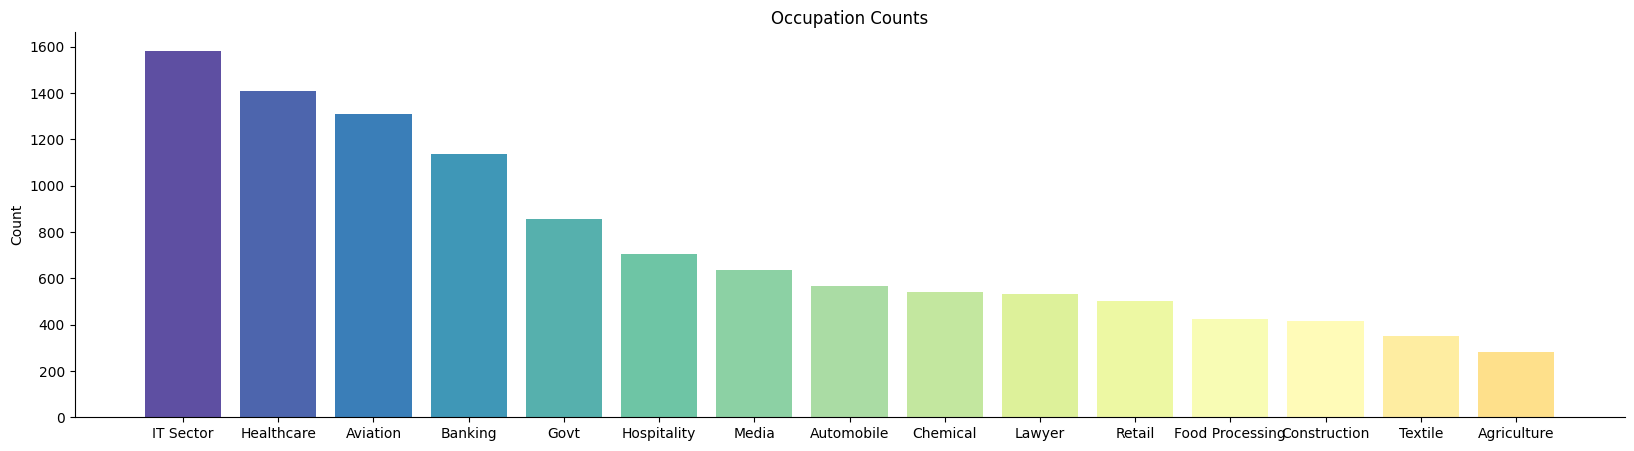

In [22]:
query = '''
select Occupation, count(*) as Count from analysis group by 1 order by 2 desc
'''
temp = pd.read_sql(query, conn)
colors = get_colors(temp, start=1, stop=0.4)
plt.bar(x=temp['Occupation'], height=temp['Count'], color=colors)

plt.xticks(rotation=0)
plt.ylabel('Count')  # Optional: add a label for y-axis
plt.title('Occupation Counts')  # Optional: add a title
plt.show()

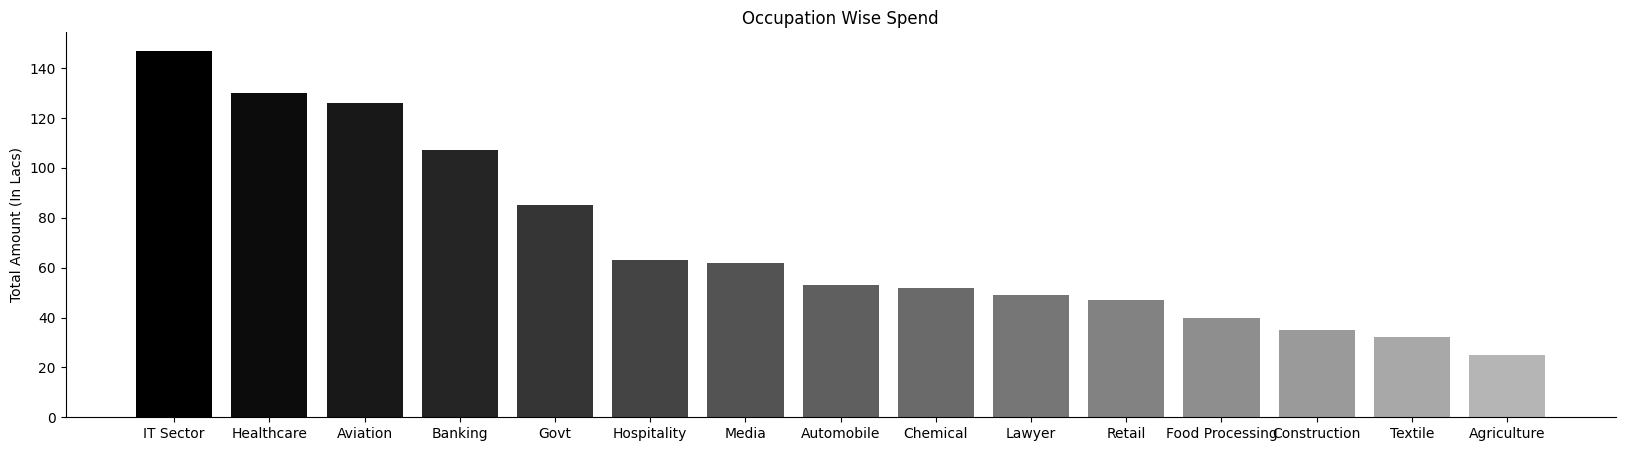

In [23]:
query = '''
select Occupation, sum(Amount)/100000 as Total_Amount from analysis group by 1 order by 2 desc
'''
temp = pd.read_sql(query, conn)
colors = get_colors(temp, start=1, stop=0.4)
plt.bar(x=temp['Occupation'], height=temp['Total_Amount'], color=colors)

plt.xticks(rotation=0)
plt.ylabel('Total Amount (In Lacs)')  # Optional: add a label for y-axis
plt.title('Occupation Wise Spend')  # Optional: add a title
plt.show()

*From above graphs we can see that most of the buyers are working in IT, Healthcare and Aviation sector*

### Product Category

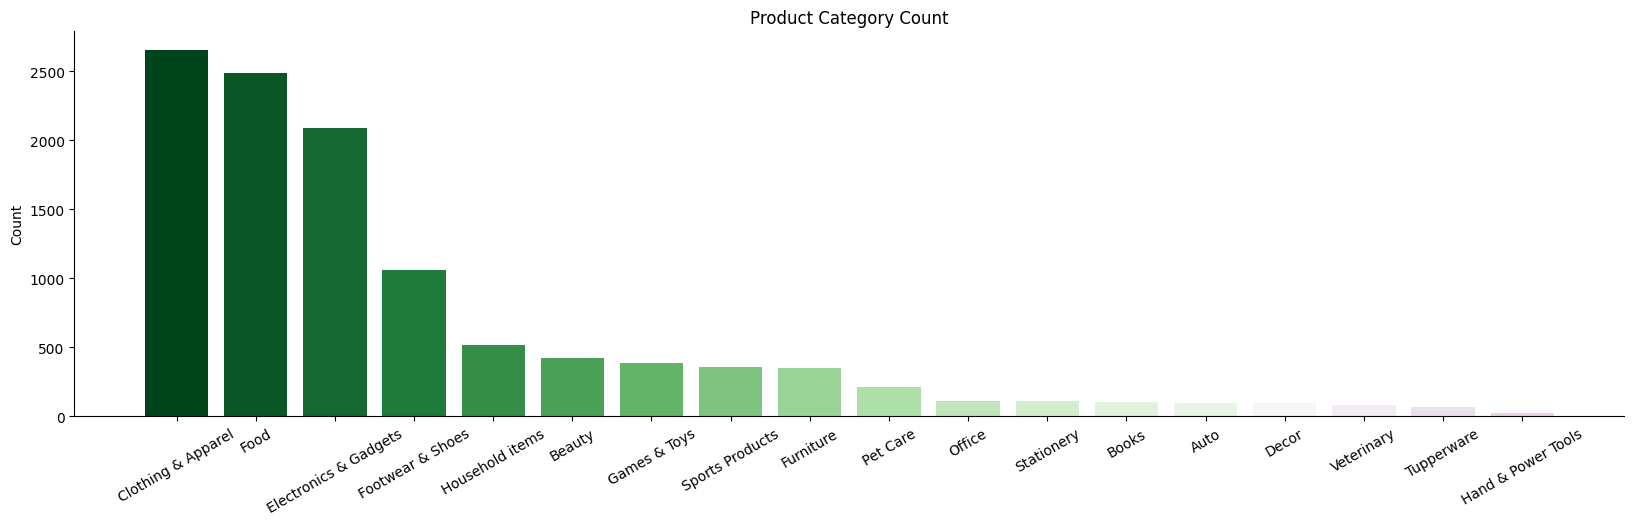

In [24]:
query = '''
select Product_Category, count(*) as Count from analysis group by 1 order by 2 desc
'''
temp = pd.read_sql(query, conn)
colors = get_colors(temp, start=1, stop=0.4)
plt.bar(x=temp['Product_Category'], height=temp['Count'], color=colors)
plt.xticks(rotation=30)
plt.ylabel('Count')  # Optional: add a label for y-axis
plt.title('Product Category Count')  # Optional: add a title
plt.show()

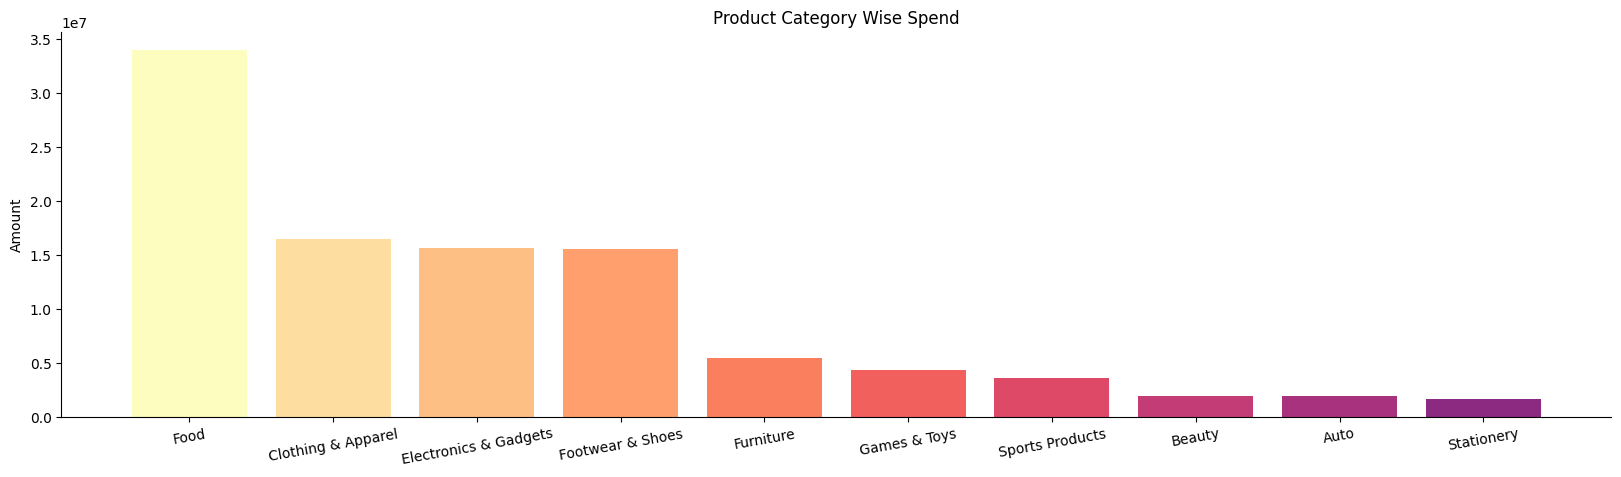

In [25]:
sales_state = df.groupby(['Product_Category'], as_index=False)['Amount'].sum()\
                            .sort_values(by='Amount', ascending=False).head(10)
colors = get_colors(sales_state, start=1, stop=0.4)
plt.bar(x=sales_state['Product_Category'], height=sales_state['Amount'], color=colors)
plt.xticks(rotation=10)
plt.ylabel('Amount')  # Optional: add a label for y-axis
plt.title('Product Category Wise Spend')  # Optional: add a title
plt.show()

*From above graphs we can see that most of the sold products are from Food, Clothing and Electronics category*

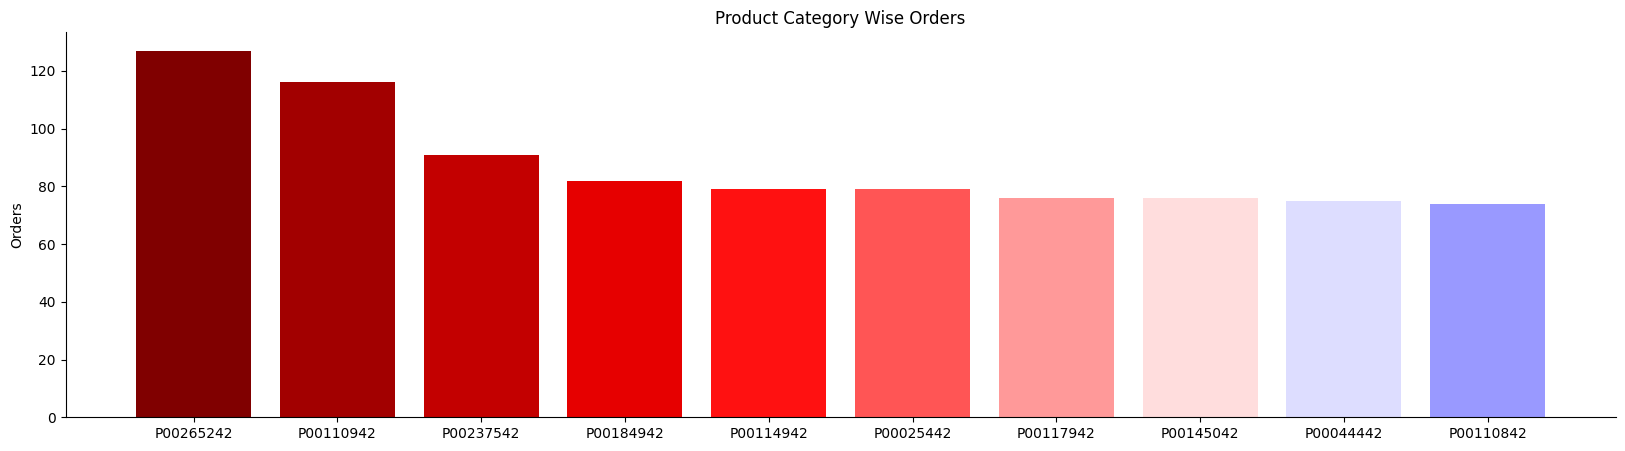

In [26]:
sales_state = df.groupby(['Product_ID'], as_index=False)['Orders'].sum()\
                .sort_values(by='Orders', ascending=False).head(10)
colors = get_colors(sales_state, start=1, stop=0.4)
plt.bar(x=sales_state['Product_ID'], height=sales_state['Orders'], color=colors)
plt.xticks(rotation=0)
plt.ylabel('Orders')  # Optional: add a label for y-axis
plt.title('Product Category Wise Orders')  # Optional: add a title
plt.show()

## Zones

In [28]:
query = '''
select Zone, count(Zone) as SalesCount, round(sum(amount)/100000.0,2) as TotalSales_L from analysis group by Zone order by 3 desc
'''
zone_df = pd.read_sql(query, conn)
zone_df

,Zone,SalesCount,TotalSales_L
0,Central,4289,416.01
1,Southern,2693,266.07
2,Western,1952,183.74
3,Northern,1491,126.19
4,Eastern,814,70.49


The above table says which zone is doing the best in terms of Sales Count and Sales Amount. Turns out Central is the best region in terms of both Sales Count and Revenue from Sales.

In [29]:
query = '''
with cte as (
select Zone, Product_Category, count(Zone) as SalesCount, sum(amount) as TotalSales from analysis
     group by 1, 2 ),

interim_cte as (select *, row_number() over(partition by Zone order by TotalSales desc) as rn from cte)

select Zone, Product_Category, SalesCount, round(TotalSales/100000.0,2) as TotalSales_L from interim_cte where rn = 1
'''
Product_Cat_df = pd.read_sql(query, conn)
Product_Cat_df

,Zone,Product_Category,SalesCount,TotalSales_L
0,Central,Food,987,136.86
1,Eastern,Food,166,22.10
2,Northern,Electronics & Gadgets,532,39.91
3,Southern,Food,542,73.26
4,Western,Food,582,77.64


The above table says which is the best product category in which Zone (Total Sales Amount Wise) and we can deduce Food Category sells the most across 4 out of 5 zones.

In [30]:
query = '''
with cte as (
select Zone, Occupation, Product_Category, count(Zone) as SalesCount, sum(amount) as TotalSales from analysis
     group by 1, 2),

interim_cte as (select *, row_number() over(partition by Zone order by TotalSales desc) as rn from cte)

select Zone, Occupation, Product_Category, SalesCount, round(TotalSales/100000.0,2) as TotalSales_L from interim_cte where rn = 1
'''
occ_df = pd.read_sql(query, conn)
occ_df

,Zone,Occupation,Product_Category,SalesCount,TotalSales_L
0,Central,IT Sector,Stationery,636,60.20
1,Eastern,IT Sector,Footwear & Shoes,110,9.86
2,Northern,IT Sector,Stationery,205,16.89
3,Southern,IT Sector,Auto,363,36.40
4,Western,Healthcare,Auto,246,24.47


The above table says which occupation sector spends the most on which Product Category. IT Sector spends most amount across 4 out of 5 Zones.

In [31]:
query = '''
with cte as (
select Zone, Marital_Status, Gender, count(Zone) as SalesCount, sum(amount) as TotalSales from analysis
     group by 1, 2),

interim_cte as (select *, row_number() over(partition by Zone order by TotalSales desc) as rn from cte)

select Zone, Marital_Status, Gender, SalesCount, round(TotalSales/100000.0,2) as TotalSales_L from interim_cte where rn = 1
'''
Status_df = pd.read_sql(query, conn)
Status_df

,Zone,Marital_Status,Gender,SalesCount,TotalSales_L
0,Central,0,M,2479,243.06
1,Eastern,0,F,466,40.08
2,Northern,0,M,869,73.79
3,Southern,0,M,1542,154.50
4,Western,0,F,1162,109.83


Unmarried Folks spend the most across all the zones and specifically unmarried males spend the highest in 3 out of 5 zones.

In [32]:
query = '''
with cte as (
select Zone, Cust_name, Gender, count(Zone) as SalesCount, sum(amount) as TotalSales from analysis
     group by 1, 2),

interim_cte as (select *, row_number() over(partition by Zone order by TotalSales desc) as rn from cte)

select Zone, Cust_name, Gender, SalesCount, round(TotalSales/100000.0,2) as TotalSales_L from interim_cte where rn = 1
'''
user_df = pd.read_sql(query, conn)
user_df

,Zone,Cust_name,Gender,SalesCount,TotalSales_L
0,Central,Vishakha,F,17,1.57
1,Eastern,Chikku,F,4,0.55
2,Northern,Shreyshi,F,10,0.88
3,Southern,Sudevi,M,11,1.31
4,Western,Indulekha,F,8,0.88


The above table shows the users who spent the most in each zone. Maybe we can give a prize to these customers to ensure they don't go anywhere else when it comes to shopping with us.

## Conclusion:

### 

*Married women age group 26-35 yrs from UP,  Maharastra and Karnataka working in IT, Healthcare and Aviation are more likely to buy products from Food, Clothing and Electronics category*